# Graph Network Analysis of Minerals

## Load and process the data

Original center_points CRS: PROJCS["MRO_Mars_Equirectangular_IAU_2000_-45_00N_-52_50E",GEOGCS["GCS_Mars_2000_IAU_IAG_custom_sphere_lat45",DATUM["D_Mars_2000_IAU_IAG_custom_sphere_lat45",SPHEROID["Mars_2000_IAU_IAG_custom_sphere_lat45",3386150.74700337,0]],PRIMEM["Reference_Meridian",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Equirectangular"],PARAMETER["standard_parallel_1",-45],PARAMETER["central_meridian",-52.5],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
Converting center points to geographic coordinates first
Center point geographic coordinates: lon=-43.99924951870422, lat=-49.700400242326666


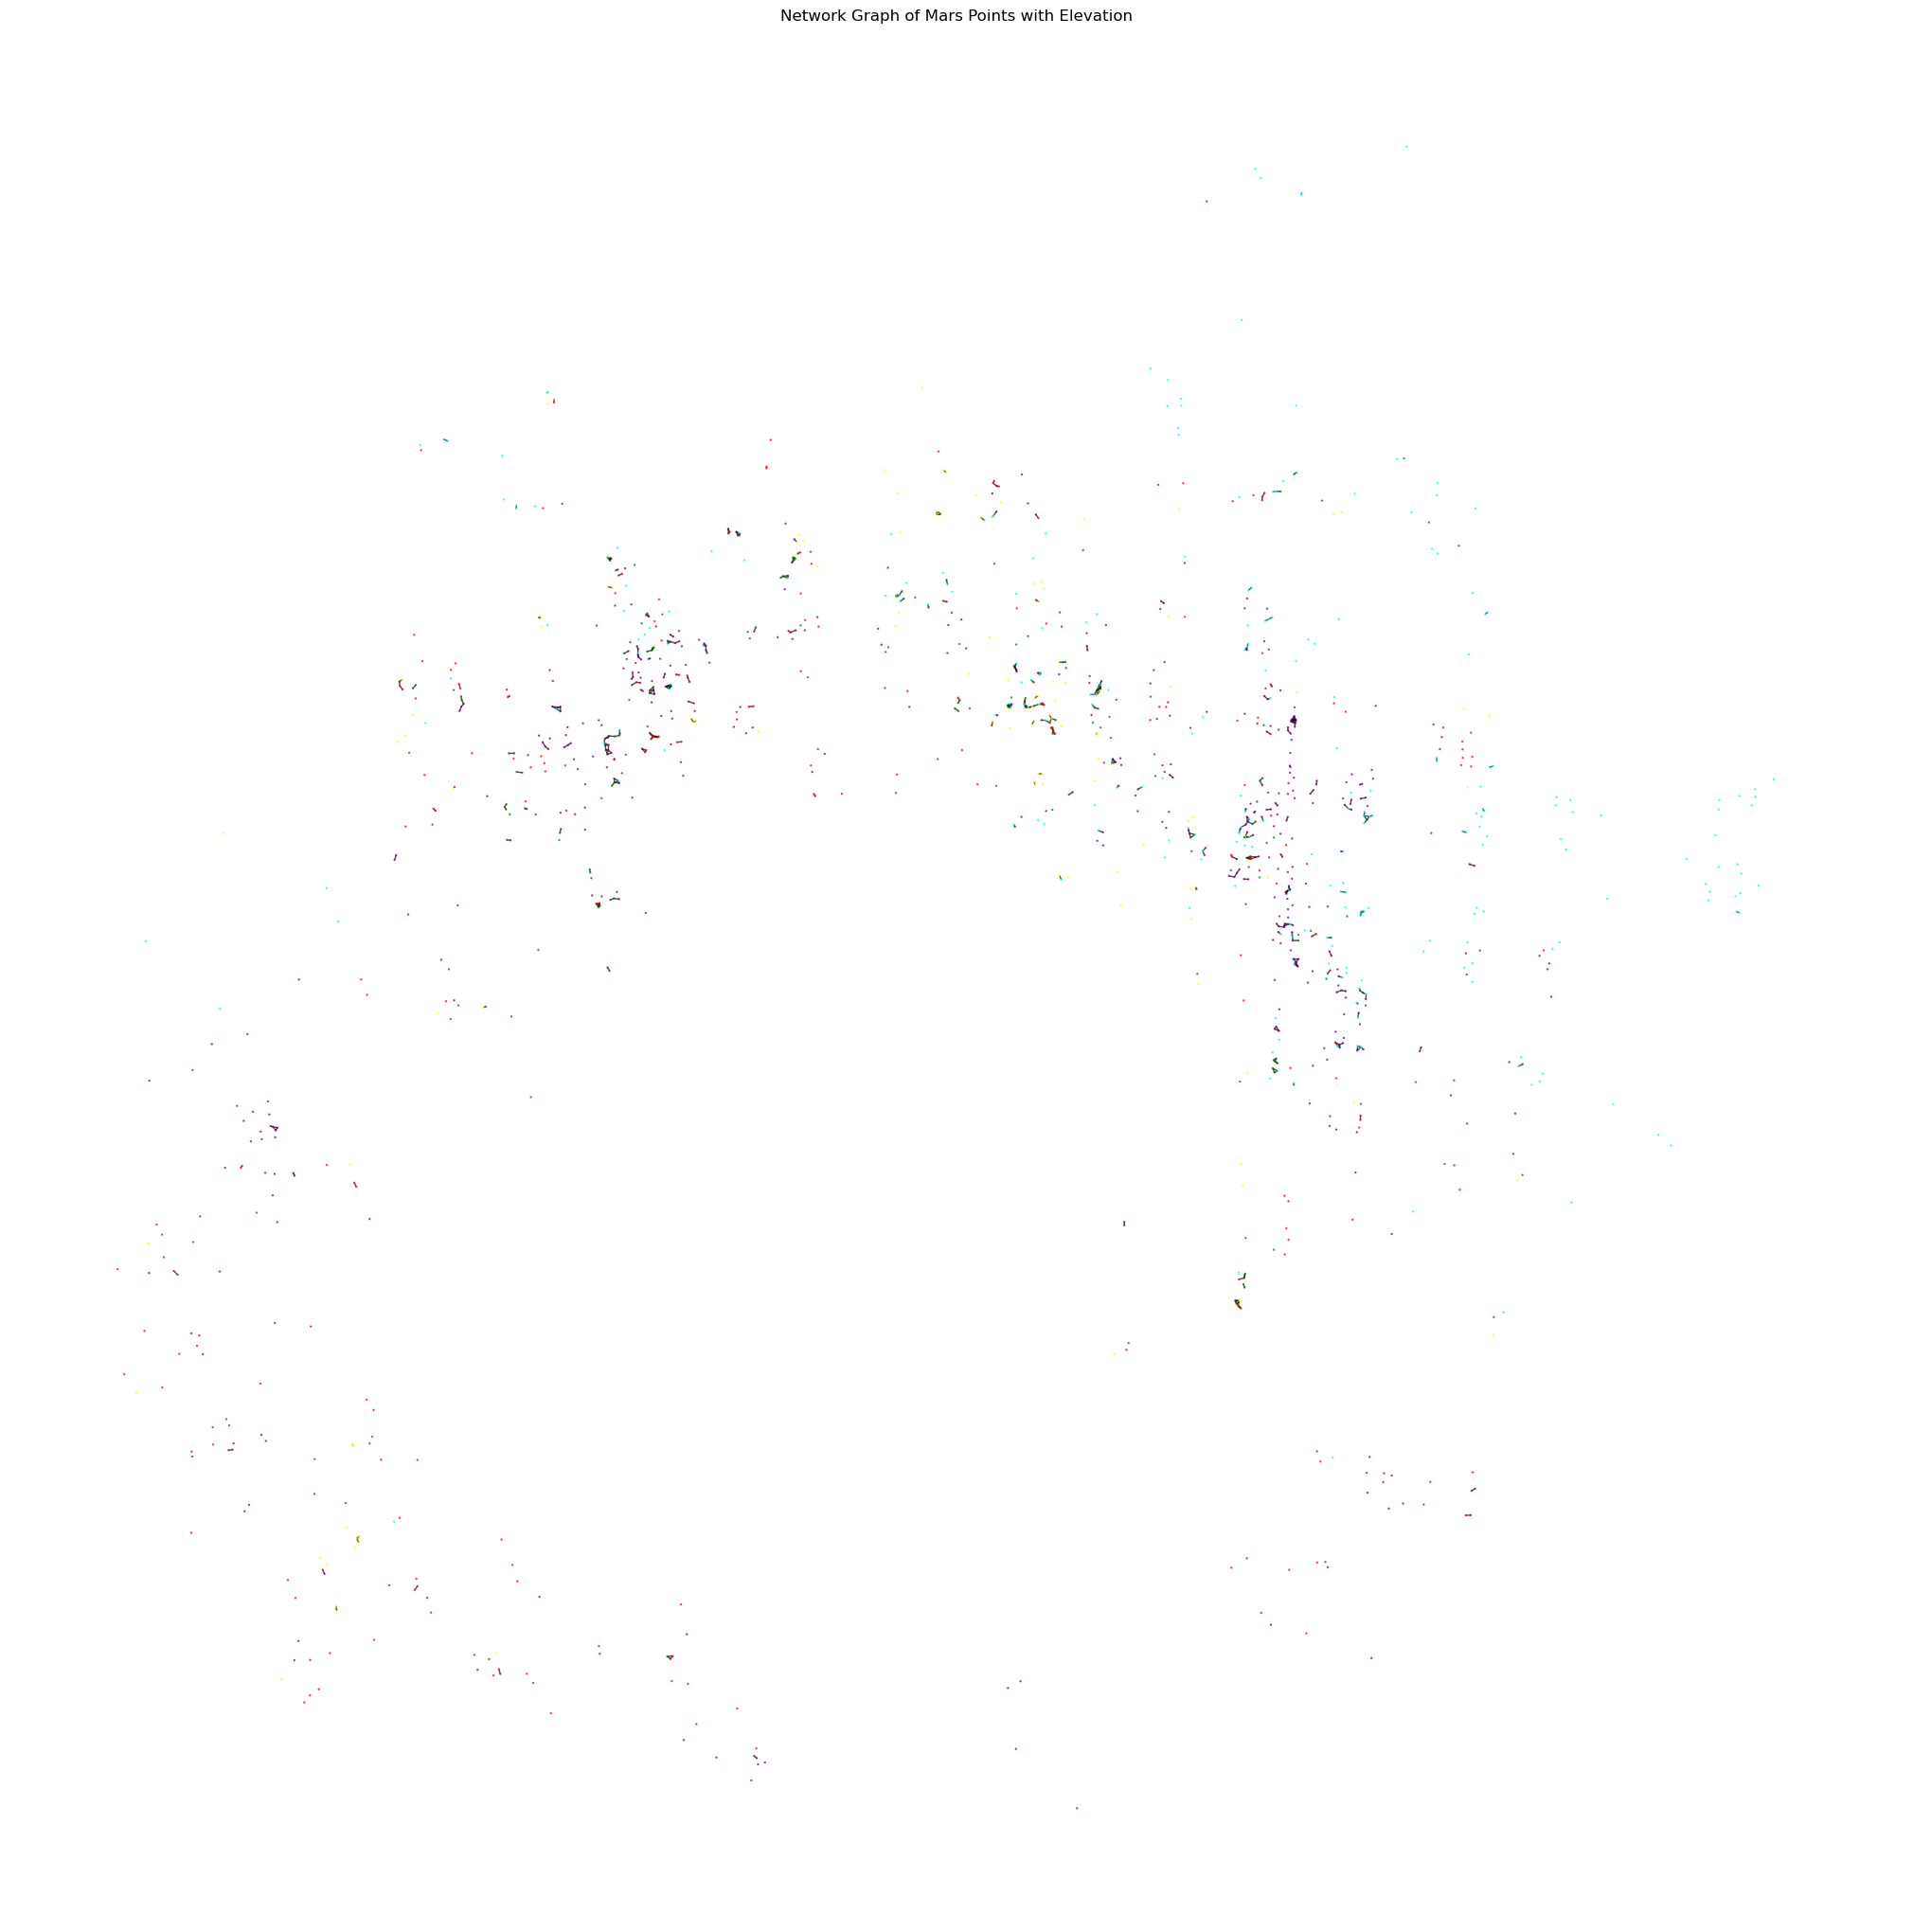

In [1]:
import geopandas as gpd
import numpy as np
import scipy.spatial as spatial
import matplotlib.pyplot as plt
import networkx as nx
import os
from scipy.spatial import distance
import math

# Radius of Mars in kilometers at Argyre (assuming ellipsoid with 3396.19, 3376.2)
R_MARS = 3384.5

def haversine(lat1, lon1, lat2, lon2):
    """
    Calculate the distance between two points on Mars (in kilometers)
    given their latitudes and longitudes.

    :param lat1: Latitude of the first point in degrees
    :param lon1: Longitude of the first point in degrees
    :param lat2: Latitude of the second point in degrees
    :param lon2: Longitude of the second point in degrees
    :return: Distance between the two points in kilometers
    """
    # Convert latitude and longitude from degrees to radians
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])

    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1

    a = (
        math.sin(dlat / 2) ** 2
        + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2) ** 2
    )
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

    # Distance in kilometers
    d = R_MARS * c
    return d


os.environ["PROJ_IGNORE_CELESTIAL_BODY"] = "YES"


def custom_distance(p1, p2):
    lon1, lat1 = p1
    lon2, lat2 = p2
    return round(haversine(lon1, lat1, lon2, lat2), 2)

def custom_distance2(p1, p2):
    x1, y1 = p1
    x2, y2 = p2
    return round(math.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2), 2)


# Load your GeoPackage file
file_path = '../data/crism_mapping_results_as_points/all_units_points_argyrePRJ_04032025.gpkg'
gdf = gpd.read_file(file_path)

# Define the categories to keep
categories_of_interest = [
    "type 1 olivine",
    "type 2 olivine",
    "plagioclase",
    "lcp",
    "hcp + olivine",
]

geounits_of_interest = [
    "Argyre basin member 2",
    "Argyre basin member 3",
    "Argyre rim materials",
    "Argyre rim and basin materials",
    "Argye rim and basin materials",
    "Argyre basin and rim materials",
    "Young crater materials",
    "Old crater materials",
]

category_colors = {
    "type 1 olivine": "green",
    "type 2 olivine": "red",
    "plagioclase": "yellow",
    "lcp": "cyan",
    "hcp + olivine": "purple",
}

# Strip leading and trailing spaces from the 'Category' column
gdf["Category"] = gdf["Category"].str.strip()

# Filter the GeoDataFrame to include only the categories of interest
gdf_filtered = gdf[gdf["Category"].isin(categories_of_interest)]
gdf_filtered = gdf_filtered[gdf_filtered["GeoUnits"].isin(geounits_of_interest)]

# Convert the Elevation_km column to meters
gdf_filtered["Elevation_m"] = gdf_filtered["Elevation_km"] * 1000

# Reset the index after filtering
gdf_filtered = gdf_filtered.reset_index(drop=True)

# count the number of each category in the graph
category_counts = gdf_filtered["Category"].value_counts()
total_counts = category_counts.sum()
percent_category_dict = {}
for category, count in category_counts.items():
    percent_category_dict[category] = count / total_counts

# Convert coordinates from degrees to meters (if needed) using an appropriate projection
iau49900 = 'GEOGCS["Mars (2015) - Sphere / Ocentric",DATUM["Mars (2015) - Sphere",SPHEROID["Mars (2015) - Sphere",3396190,0,AUTHORITY["IAU","49900"]],AUTHORITY["IAU","49900"]],PRIMEM["Reference Meridian",0,AUTHORITY["IAU","49900"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["IAU","49900"]]'

# ----
from rasterio.crs import CRS
center_point_path = '../data/dohm_2015_map_units/arygre_center_point.shp'

# Load the geological units and center point(s)
center_points = gpd.read_file(center_point_path)

# Print CRS information for debugging
print("Original center_points CRS:", center_points.crs)

# Define Mars-specific coordinate systems
# Mars geographic coordinate system (lat/lon)
mars_geographic_crs = CRS.from_string('+proj=longlat +a=3396190 +b=3376200 +no_defs +type=crs')

# We need to check if the center points are already in a geographic CRS
# If they're in a projected CRS, we need to convert them to geographic first
# to get proper lat/lon values

# Create a temporary copy of center_points in geographic coordinates if needed
if not center_points.crs.is_geographic:
    print("Converting center points to geographic coordinates first")
    # If we don't know what the current CRS is, we can try using EPSG:3857 or 3395 (common Mars projections)
    # or we can use the existing CRS if it's defined
    if center_points.crs is None:
        print("Warning: center_points has no CRS defined. Assuming EPSG:3857")
        center_points_temp = center_points.copy()
        center_points_temp.crs = "EPSG:3857"
        center_points_geo = center_points_temp.to_crs(mars_geographic_crs)
    else:
        center_points_geo = center_points.to_crs(mars_geographic_crs)
else:
    center_points_geo = center_points.copy()

# Now get the geographic coordinates (these should be proper lat/lon values)
center_lon = center_points_geo.geometry.x.mean()
center_lat = center_points_geo.geometry.y.mean()
print(f"Center point geographic coordinates: lon={center_lon}, lat={center_lat}")

# Set standard parallels 10 degrees away from the center latitude
std_parallel1 = max(-90, center_lat - 10)  # Ensure we don't go below -90
std_parallel2 = min(90, center_lat + 10)   # Ensure we don't go above 90

# Define a Mars Equidistant Conic projection centered on the Argyre basin
# This is suitable for accurate distance measurements around a central point
mars_projected_crs = CRS.from_string(
    f'+proj=eqdc +lat_0={center_lat} +lon_0={center_lon} +lat_1={std_parallel1} +lat_2={std_parallel2} '
    '+a=3396190 +b=3376200 +units=m +no_defs +type=crs'
)
iau49900 = mars_projected_crs
# ----

gdf_filtered = gdf_filtered.to_crs(iau49900)  # Set to Mars-specific CRS

# Extract coordinates (X, Y) and convert them into a numpy array
coords = np.array([point.coords[0] for point in gdf_filtered.geometry])

# Create a spatial index to efficiently find the nearest neighbors
tree = spatial.cKDTree(coords)

# Set a threshold distance (e.g., 5 km) to connect nearby points
threshold_distance = 5000  # in meters

# convert threshold distance to degrees
threshold_distance_deg = (threshold_distance / R_MARS) * (180 / math.pi)

dist_matrix = distance.cdist(coords, coords, metric=custom_distance)

# Create an empty graph
G = nx.Graph()

# Add nodes to the graph, incorporate elevation in the position
for idx, row in gdf_filtered.iterrows():
    G.add_node(
        idx,
        label=row["Category"],
        position=(coords[idx][0], coords[idx][1], row["Elevation_m"]),
    )

# Add edges based on proximity (i.e., distance threshold)
for i, point1 in enumerate(coords):
    # Query for all points within the threshold distance
    nearby_points = tree.query_ball_point(point1, threshold_distance, p=2, eps=0.1) #threshold_distance_deg)
    for j in nearby_points:
        if i != j:
            G.add_edge(i, j, weight=custom_distance2(coords[i], coords[j]))
            G.add_edge(j, i, weight=custom_distance2(coords[i], coords[j]))

node_colors = [
    category_colors[G.nodes[node]["label"]] for node in G.nodes
]  # Use category for color

# Plot the network graph
plt.figure(figsize=(20, 20))

# Get positions for plotting, include elevation in z-axis (3D plot)
pos = {
    node: (G.nodes[node]["position"][0], G.nodes[node]["position"][1])
    for node in G.nodes
}

# Draw the network graph
nx.draw(
    G,
    pos,
    with_labels=False,
    node_color=node_colors,
    node_size=0.5,  # Adjust the node size here
    font_size=8,
    font_weight="bold",
    alpha=0.7,
)

plt.title("Network Graph of Mars Points with Elevation")
plt.show()

## Optionally export nodes and edges for plotting in QGIS

In [ ]:
# Create GeoDataFrames for nodes and edges

import geopandas as gpd
from shapely.geometry import Point, LineString

# Create a GeoDataFrame for nodes
node_data_list = []
for node_id, node_data in G.nodes(data=True):
    x, y, z = node_data['position']
    node_data_list.append({
        'id': node_id,
        'category': node_data['label'],
        'elevation': z,
        'geometry': Point(x, y)
    })
    
nodes_gdf = gpd.GeoDataFrame(node_data_list, crs=iau49900)

# Create a GeoDataFrame for edges
edge_data = []
for u, v, data in G.edges(data=True):
    u_pos = G.nodes[u]['position']
    v_pos = G.nodes[v]['position']
    edge_data.append({
        'from_node': u,
        'to_node': v,
        'weight': data['weight'],
        'geometry': LineString([(u_pos[0], u_pos[1]), (v_pos[0], v_pos[1])])
    })
    
edges_gdf = gpd.GeoDataFrame(edge_data, crs=iau49900)

## Export to GeoJSON
# nodes_gdf.to_file(f'../data/mars_nodes_{threshold_distance}m_proj.geojson', driver='GeoJSON')
# edges_gdf.to_file(f'../data/mars_edges_{threshold_distance}m_proj.geojson', driver='GeoJSON')

## Create df of elevation diffs for later plotting & analysis

In [3]:
import numpy as np
import pandas as pd

# Create a list to store the relative elevation differences with categories
elevation_diff_data = []

# Iterate through all edges in the graph
for node1, node2 in G.edges():
    # Get the elevation values for the two nodes
    elevation_node1 = G.nodes[node1]["position"][
        2
    ]  # z-coordinate is the elevation (in meters)
    elevation_node2 = G.nodes[node2]["position"][2]

    # Get the categories of the nodes
    category_node1 = gdf_filtered.loc[node1, "Category"]
    category_node2 = gdf_filtered.loc[node2, "Category"]

    # Get the pn of the nodes
    pn_node1 = gdf_filtered.loc[node1, "Polygon Number"]
    pn_node2 = gdf_filtered.loc[node2, "Polygon Number"]

    # Get the pn of the nodes
    tn_node1 = gdf_filtered.loc[node1, "Source File"]
    tn_node2 = gdf_filtered.loc[node2, "Source File"]

    # Calculate the distance between the two nodes (already in kilometers)
    distance_km = G[node1][node2]["weight"] / 1000

    # Check if the nodes are within the threshold distance (e.g., 5 km)
    if distance_km <= 5:
        # Calculate the relative elevation difference
        # elevation_diff = elevation_node1 - elevation_node2
        elevation_diff = elevation_node2 - elevation_node1

        # Store the data including categories
        elevation_diff_data.append(
            {
                "node1": node1,
                "node2": node2,
                "distance_km": distance_km,
                "category_node1": category_node1,
                "category_node2": category_node2,
                "elevation_node1": elevation_node1,
                "elevation_node2": elevation_node2,
                "elevation_diff": elevation_diff,
                "pn_node1": pn_node1,
                "pn_node2": pn_node2,
                "tn_node1": tn_node1,
                "tn_node2": tn_node2,
            }
        )

# Convert the data into a DataFrame for easier analysis
elevation_diff_df = pd.DataFrame(elevation_diff_data)

# Display basic statistics about the relative elevation differences
elevation_diff_stats = elevation_diff_df.describe()

# Display the DataFrame with the elevation differences and statistics
elevation_diff_df.head(), elevation_diff_stats

# # optionally save
# elevation_diff_df.to_excel('elevation_diff_data.xlsx')

(   node1  node2  distance_km  category_node1  category_node2  elevation_node1  \
 0      8      9      4.26793  type 2 olivine   hcp + olivine       169.085106   
 1     17     18      3.55039  type 2 olivine  type 2 olivine      -234.344828   
 2     18     19      4.24219  type 2 olivine  type 2 olivine      -541.957295   
 3     20     23      2.31847             lcp             lcp     -1076.194030   
 4     22     23      4.32007  type 1 olivine             lcp       -20.688525   
 
    elevation_node2  elevation_diff pn_node1 pn_node2 tn_node1 tn_node2  
 0       103.923077      -65.162029       18       20    T0507    T0507  
 1      -541.957295     -307.612468       46       48    T0507    T0507  
 2     -1351.631429     -809.674133       48       50    T0507    T0507  
 3      -878.681818      197.512212       52       60    T0507    T0507  
 4      -878.681818     -857.993294       58       60    T0507    T0507  ,
              node1        node2  distance_km  elevation_node

## Perform a statistical test of significance in elevation differences among mineral categories 

### create connected elevations dictionary

In [5]:
import matplotlib.pyplot as plt

category_colors = {
    "type 1 olivine": "tab:green",
    "type 2 olivine": "tab:red",
    "hcp + olivine": "mediumpurple",
    "lcp": "tab:cyan",
    "plagioclase": "gold",
}

connected_elevations_dict = {}


for ref_cat in category_colors.keys():
    # Create lists to store data
    plagioclase_distances = []
    plagioclase_elevations = []
    connected_elevations = []
    connected_categories = []
    
    # Iterate through all edges in the graph
    for node1, node2 in G.edges():
        # Get the category of node1 (the source node)
        category_node1 = gdf_filtered.loc[node1, "Category"]
        category_node2 = gdf_filtered.loc[node2, "Category"]

        if category_node1 == ref_cat:
            # Get the elevation of node1
            distance_node1 = gdf_filtered.loc[node1, "Distance_to_center_km"]
            elevation_node1 = G.nodes[node1]["position"][2]

            # Get the elevation of node2 (connected node)
            elevation_node2 = G.nodes[node2]["position"][2]

            # Append the data for plotting
            plagioclase_distances.append(distance_node1)
            plagioclase_elevations.append(elevation_node1)
            # connected_elevations.append(elevation_node1 - elevation_node2)
            connected_elevations.append(elevation_node2 - elevation_node1)
            connected_categories.append(category_node2)
        elif category_node2 == ref_cat and category_node1 != ref_cat:
            # Get the elevation of node2
            distance_node2 = gdf_filtered.loc[node2, "Distance_to_center_km"]
            elevation_node2 = G.nodes[node2]["position"][2]

            # Get the elevation node1 (connected node)
            elevation_node1 = G.nodes[node1]["position"][2]

            # Append the data for plotting
            plagioclase_distances.append(distance_node2)
            plagioclase_elevations.append(elevation_node2)
            # connected_elevations.append(elevation_node2 - elevation_node1)
            connected_elevations.append(elevation_node1 - elevation_node2)
            connected_categories.append(category_node1)
    connected_elevations_dict[ref_cat] = connected_elevations

### perform analysis 

9.05361424755573 3.7020465539384223e-07


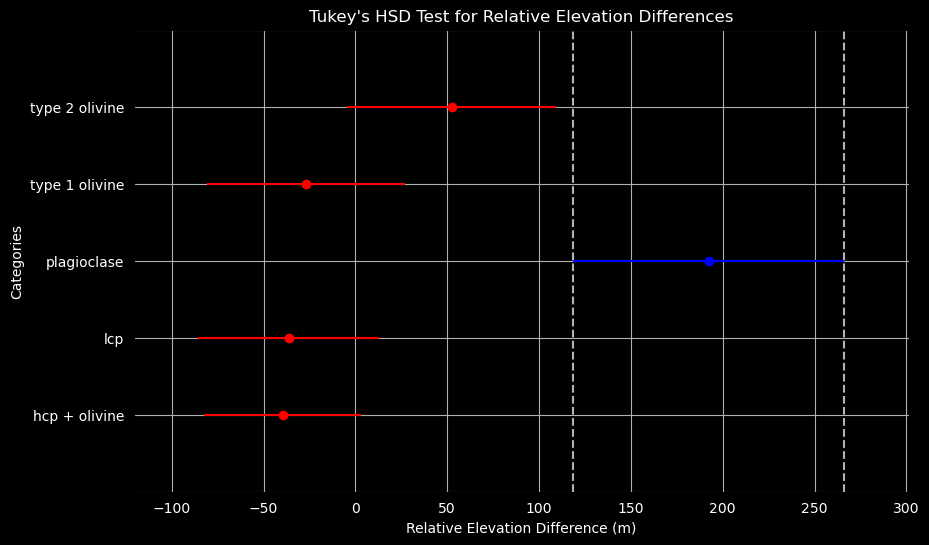

group1,group2,meandiff,p-adj,lower,upper,reject
hcp + olivine,lcp,3.2517,1.0,-87.8526,94.356,False
hcp + olivine,plagioclase,232.0202,0.0,114.5592,349.4813,True
hcp + olivine,type 1 olivine,12.8166,0.9963,-83.6395,109.2728,False
hcp + olivine,type 2 olivine,92.0676,0.0873,-7.8337,191.9688,False
lcp,plagioclase,228.7686,0.0,105.648,351.8891,True
lcp,type 1 olivine,9.5649,0.9991,-93.7083,112.8382,False
lcp,type 2 olivine,88.8159,0.1524,-17.6822,195.3139,False
plagioclase,type 1 olivine,-219.2036,0.0,-346.3353,-92.0719,True
plagioclase,type 2 olivine,-139.9527,0.0271,-269.7176,-10.1878,True
type 1 olivine,type 2 olivine,79.2509,0.2918,-31.86,190.3619,False


In [ ]:
# run an anova to see if the relative elevation differences are significantly different
import scipy.stats as stats

# Perform one-way ANOVA
# first, remove any NaN values
connected_elevations_dict = {
    key: [-val for val in connected_elevations if not np.isnan(val)]
    for key, connected_elevations in connected_elevations_dict.items()
}
f_stat, p_value = stats.f_oneway(
    connected_elevations_dict["hcp + olivine"],
    connected_elevations_dict["lcp"],
    connected_elevations_dict["type 1 olivine"],
    connected_elevations_dict["plagioclase"],
    connected_elevations_dict["type 2 olivine"],
    # connected_elevations_dict["hcp + lcp"],
)

# Display the F-statistic and p-value
print(f_stat, p_value)

# perform a multiple comparison test
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Combine all the data into a single array
all_data = np.concatenate(
    [
        connected_elevations_dict["hcp + olivine"],
        connected_elevations_dict["lcp"],
        connected_elevations_dict["type 1 olivine"],
        connected_elevations_dict["plagioclase"],
        connected_elevations_dict["type 2 olivine"],
        # connected_elevations_dict["hcp + lcp"],
    ]
)
# Create labels for the groups
group_labels = (
    ["hcp + olivine"] * len(connected_elevations_dict["hcp + olivine"])
    + ["lcp"] * len(connected_elevations_dict["lcp"])
    + ["type 1 olivine"] * len(connected_elevations_dict["type 1 olivine"])
    + ["plagioclase"] * len(connected_elevations_dict["plagioclase"])
    + ["type 2 olivine"] * len(connected_elevations_dict["type 2 olivine"])
)

# Perform Tukey's HSD test
tukey_results = pairwise_tukeyhsd(all_data, group_labels, alpha=0.05)

# Plot the results of the Tukey's HSD test
fig, ax = plt.subplots(figsize=(10, 6))

tukey_results.plot_simultaneous(comparison_name="plagioclase", ax=ax)
# tukey_results.plot_simultaneous(comparison_name="hcp + olivine", ax=ax)
# tukey_results.plot_simultaneous(comparison_name='lcp', ax=ax)
# tukey_results.plot_simultaneous(comparison_name='type 1 olivine', ax=ax)
# tukey_results.plot_simultaneous(comparison_name='type 2 olivine', ax=ax)
# tukey_results.plot_simultaneous(comparison_name='hcp + lcp', ax=ax)

plt.gca().set_facecolor("black")  # Axes background color
plt.gcf().set_facecolor("black")  # Figure background color
plt.title("Tukey's HSD Test for Relative Elevation Differences", color="white")
plt.xlabel("Relative Elevation Difference (m)", color="white")
plt.ylabel("Categories", color="white")
plt.grid(True)
plt.xticks(color="white")
plt.yticks(color="white")
plt.show()


# Display the results of the Tukey's HSD test
tukey_results.summary()

## Create Symmetric Co-Occurence Matrix

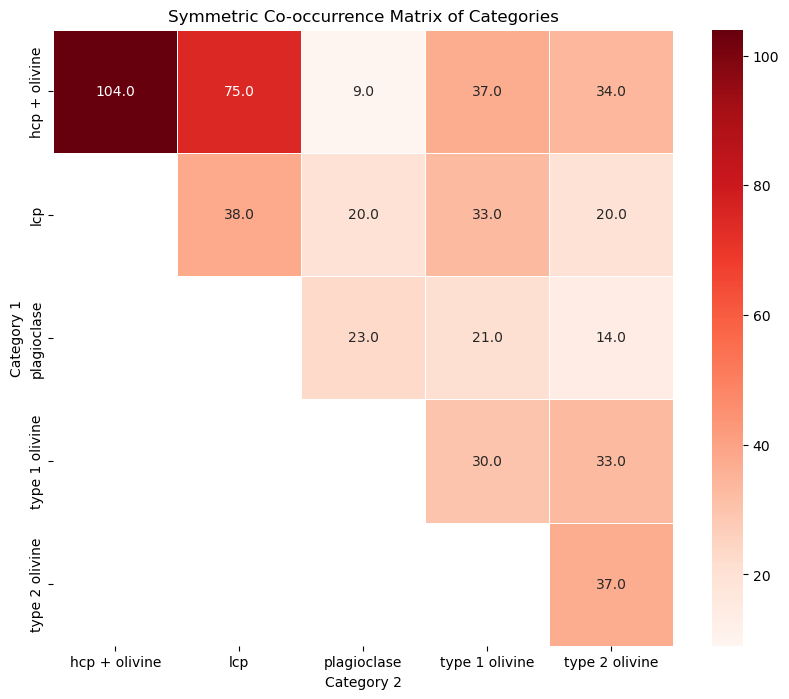

In [14]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Initialize a dictionary to store the co-occurrence counts
co_occurrence = {}

distance_weight = False

# Iterate through the edges of the graph
for node1, node2, data in G.edges(data=True):
    
    category1 = gdf_filtered.loc[node1, "Category"]
    category2 = gdf_filtered.loc[node2, "Category"]

    # Increment co-occurrence counts for each pair of categories
    # if category1 != category2:
    pair = tuple(sorted([category1, category2]))  # Sort the pair to make it symmetric
    if pair not in co_occurrence:
        co_occurrence[pair] = 0
    if distance_weight:
        co_occurrence[pair] += 1 / (data["weight"] / 1000)
    else:
        co_occurrence[pair] += 1

# Convert the dictionary into a pandas DataFrame for easier visualization
category_pairs = list(co_occurrence.keys())
counts = list(co_occurrence.values())

co_occurrence_df = pd.DataFrame(
    {
        "Category 1": [pair[0] for pair in category_pairs],
        "Category 2": [pair[1] for pair in category_pairs],
        "Co-occurrence Count": counts,  # /percent_category_dict[pair[0]]
    }
)

# Pivot the dataframe to create the co-occurrence matrix
co_occurrence_matrix = co_occurrence_df.pivot(
    index="Category 1", columns="Category 2", values="Co-occurrence Count"
).fillna(np.nan)

# Visualize the symmetric co-occurrence matrix
plt.figure(figsize=(10, 8))
sns.heatmap(co_occurrence_matrix, annot=True, cmap="Reds", fmt=".1f", linewidths=0.5)
plt.title("Symmetric Co-occurrence Matrix of Categories")
plt.show()